In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import GCCA, shuffle_block, data_superbowl, corr_component, avg_corr_coe
from sklearn.covariance import LedoitWolf
from numpy import linalg as LA
from scipy import signal
from tqdm import tqdm

In [2]:
# data = scipy.io.loadmat('../Correlated Component Analysis/data/Prepro_EEG.mat')
# X_prepro = data['X']
# fs = 256
# T, D, N = X_prepro.shape

In [3]:
head = '../Correlated Component Analysis/data'
datatype = 'preprocessed'
year = '2013'
view = 'Y2'
X_prepro, fs = data_superbowl(head=head, datatype=datatype, year=year, view=view)
T, D, N = X_prepro.shape

In [4]:
n_components = 5
lam, W_stack, avg_corr = GCCA(X_prepro, n_components=n_components, regularization='lwcov')
avg_corr

array([0.18005508, 0.0991119 , 0.08692264, 0.08293346, 0.08498307])

In [5]:
avg_corr_coe(X_prepro, W_stack, N, n_components=n_components)

array([0.18064173, 0.09982907, 0.08778709, 0.08382344, 0.08573119])

In [6]:
(1/lam-1)/(N-1)

array([0.18236032, 0.10144515, 0.08967117, 0.08887496, 0.08700949])

Difference between avg_corr and the one computed by function `avg_corr_coe` is due to the regularization when computing covariance matrices.

(1/lam-1)/(N-1) is an approximation of real average pairwise correlation. It assumes that $\mathbf w_n^H \mathbf R_{\mathbf x_n \mathbf x_n} \mathbf w_n$ is equal for all $n$ (different subject), which is not true. In all cases we have here, this approximation is actually good enough.

### Permutation Test

In [7]:
num_test = 1000
pm_n_components = 200
lam_topK = np.empty((0, pm_n_components))
corr_topK = np.empty((0, pm_n_components))
for i in tqdm(range(num_test)):
    X_shuffled = shuffle_block(X_prepro, t=3, fs=fs)
    lam_permu, W_permu, corr_permu = GCCA(X_shuffled, n_components=pm_n_components, regularization='lwcov')
    lam_topK = np.concatenate((lam_topK, np.expand_dims(lam_permu, axis=0)), axis=0)
    corr_topK = np.concatenate((corr_topK, np.expand_dims(corr_permu, axis=0)), axis=0)

100%|██████████| 1000/1000 [1:15:42<00:00,  4.54s/it]


Component 118, top 1.4000000000000001%


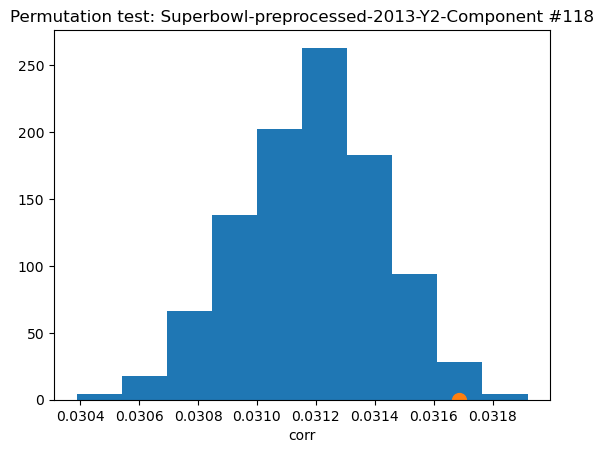

In [10]:
compo = 118
_, _, avg_corr = GCCA(X_prepro, n_components=pm_n_components, regularization='lwcov')
signifi = sum(corr_topK[:,compo-1]>avg_corr[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.hist(corr_topK[:,compo-1])
# plt.title('Permutation test: Example-'+'Component #'+str(compo))
plt.title('Permutation test: Superbowl-'+datatype+'-'+year+'-'+view+'-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(avg_corr[compo-1], 0, marker="o", markersize=10)

### Cross-validation

In [11]:
fold = 10
cv_n_components = 5
corr_train = np.zeros((fold, cv_n_components))
corr_test = np.zeros_like(corr_train)
T, D, N = X_prepro.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_prepro[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_prepro, range(len_test*i, len_test*(i+1)), axis=0)
    _, W_train, corr_train[i,:] = GCCA(X_train, n_components=n_components, regularization='lwcov')
    # corr_train[i,:] = avg_corr_coe(X_train, W_train, N, n_components=cv_n_components)
    _, _, corr_test[i,:] = GCCA(X_test, n_components=n_components, regularization='lwcov', W_train=W_train)

In [12]:
np.mean(corr_train, axis=0)

array([0.1828905 , 0.1031513 , 0.09170862, 0.09049872, 0.08981684])

In [13]:
np.mean(corr_test, axis=0)

array([ 0.11516844,  0.02993057, -0.00094616,  0.00425634,  0.00174643])

### GCCA vs Correlated Component Analysis

In [14]:
fold = 10
cv_n_components = 5
ISC_train = np.zeros((fold, cv_n_components))
ISC_test = np.zeros_like(ISC_train)
T, D, N = X_prepro.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_prepro[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_prepro, range(len_test*i, len_test*(i+1)), axis=0)
    ISC_train[i,:], W_train = corr_component(X_train, n_components=n_components)
    ISC_test[i,:], _ = corr_component(X_test, n_components=n_components, W_train=W_train)

In [15]:
np.mean(ISC_train, axis=0)

array([0.11514458, 0.04036184, 0.02881643, 0.02289647, 0.02139846])

In [16]:
np.mean(ISC_test, axis=0)

array([ 0.10402141,  0.02557607,  0.01402412,  0.00371617, -0.00083705])